# OpenVaccine: COVID-19 mRNA Vaccine Degradation Prediction

[kaggle competition site](https://www.kaggle.com/c/stanford-covid-vaccine) 

Dataset description:
- train set:                    2400 examples of length=107 and scoring_length=68
- public test set:              629  examples of length=107 and scoring_length=68
- private test set:             3005 examples of length=130 and scoring_length=91

### TODO:
- [X] no testing model, one model with different testing and training outputs
- [ ] augmentation
- [X] GCN
- [X] sequence fragmentation and similarieties finding

## Import section

In [1]:
%%time
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Dense, Input, TimeDistributed, Concatenate, Lambda, Bidirectional, Dropout, RNN
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD

import spektral
from spektral.layers import GraphConv, GraphAttention, GlobalAttentionPool

import seaborn as sns
import numpy as np
import pandas as pd

from data_preparation import *
from visualization import *
from custom_layers.subgraphing import Subgraphing
from custom_layers.custom_lstm_cell import CustomLSTMCell
from custom_layers.graph_lstm import GraphLSTM, GraphLSTMCell
from custom_layers.graph_reduce_cell import GraphReduceCell
from submissions.submit import *

import time
from datetime import datetime

CPU times: user 3.19 s, sys: 1.42 s, total: 4.6 s
Wall time: 28.7 s


In [2]:
%load_ext tensorboard

# Data Loading

In [3]:
# Dataset constants
STACKED_FEATURES_SIZE = 14
EDGES_FEATURES_MATRIX_DEPTH = 3
NEIGHBOURHOOD_SIZE = 15

In [4]:
%time raw_train_valid_ds, raw_public_test_ds, raw_private_test_ds = get_raw_datasets()

CPU times: user 2.61 s, sys: 737 ms, total: 3.35 s
Wall time: 3.44 s


In [5]:
%time subgraphed_train_valid_ds, subgraphed_public_test_ds, subgraphed_private_test_ds = load_subgraphed_datasets(neighbourhood_size=15) 

CPU times: user 513 ms, sys: 370 ms, total: 883 ms
Wall time: 6.21 s


# Model

### Definition

In [10]:
def create_model_for_subgraphed_dataset(neighbourhood_size, stacked_features_size, edges_features_matrix_depth, units):
    # Define inputs
    sequence = Input(shape=(None, 4), name='sequence')
    structure = Input(shape=(None, 3), name='structure')
    loop_type = Input(shape=(None, 7), name='predicted_loop_type')
    
    not_subgraphed_inputs = (sequence, structure, loop_type)
    
    subgraphed_stacked_base_features = Input(shape=(None, neighbourhood_size, stacked_features_size), name='stacked_base_features')
    subgraphed_adjacency_matrices = Input(shape=(neighbourhood_size, None, None), name='adjacency_matrix')
    subgraphed_edges_features_matrices = Input(shape=(neighbourhood_size, None, None, edges_features_matrix_depth), name='edges_features_matrix')

    subgraphed_inputs = (subgraphed_stacked_base_features, subgraphed_adjacency_matrices, subgraphed_edges_features_matrices)
    
    inputs = not_subgraphed_inputs + subgraphed_inputs
    
    # Main processing
    x = Concatenate()(not_subgraphed_inputs)
    seq = Bidirectional(LSTM(units, return_sequences=True))(x)
    embedded_subgraphs_seq = Bidirectional(RNN(GraphLSTMCell(units), return_sequences=True))(subgraphed_inputs)
    
    x = Concatenate()([seq, embedded_subgraphs_seq])
    
    x = TimeDistributed(Dense(512, activation='relu'))(x)
    
    # Define outputs
    reactivity_pred = TimeDistributed(Dense(1), name='reactivity')(x)
    deg_Mg_pH10_pred = TimeDistributed(Dense(1), name='deg_Mg_pH10')(x)
    deg_Mg_50C_pred = TimeDistributed(Dense(1), name='deg_Mg_50C')(x)

    scored_outputs = [reactivity_pred, deg_Mg_pH10_pred, deg_Mg_50C_pred]
    stacked_scored_outputs = Concatenate(axis=2, name='stacked_outputs')(scored_outputs)
    outputs = {'stacked_scored_labels': stacked_scored_outputs}

    model = Model(inputs=inputs, outputs=outputs)
    
    return model

Submissions are scored using MCRMSE (mean columnwise root mean squared error):
$\textrm{MCRMSE} = \frac{1}{N_{t}}\sum_{j=1}^{N_{t}}\sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_{ij} - \hat{y}_{ij})^2}$

In [11]:
def mcrmse(y_true, y_pred):
    rmse = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=1))
    return tf.reduce_mean(rmse, axis=1)

### Instantiation

In [12]:
UNITS = 128

model = create_model_for_subgraphed_dataset(NEIGHBOURHOOD_SIZE, STACKED_FEATURES_SIZE, EDGES_FEATURES_MATRIX_DEPTH, UNITS)

log_dir = os.path.join(os.getcwd(), 'logs')
model_name = datetime.now().strftime('model_%Y_%m_%d__%H_%M_%S')
model_log_dir = os.path.join(log_dir, model_name)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=model_log_dir, histogram_freq=0, update_freq='epoch')

model_file_name = model_name
models_path = os.path.join(os.getcwd(), 'models')
model_path = os.path.join(models_path, model_file_name)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_path, moniotr='val_loss', verbose=1, save_best_only=True, period=10)

model.compile(loss=mcrmse,
#               optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9),
              optimizer='adam')

### Inspection

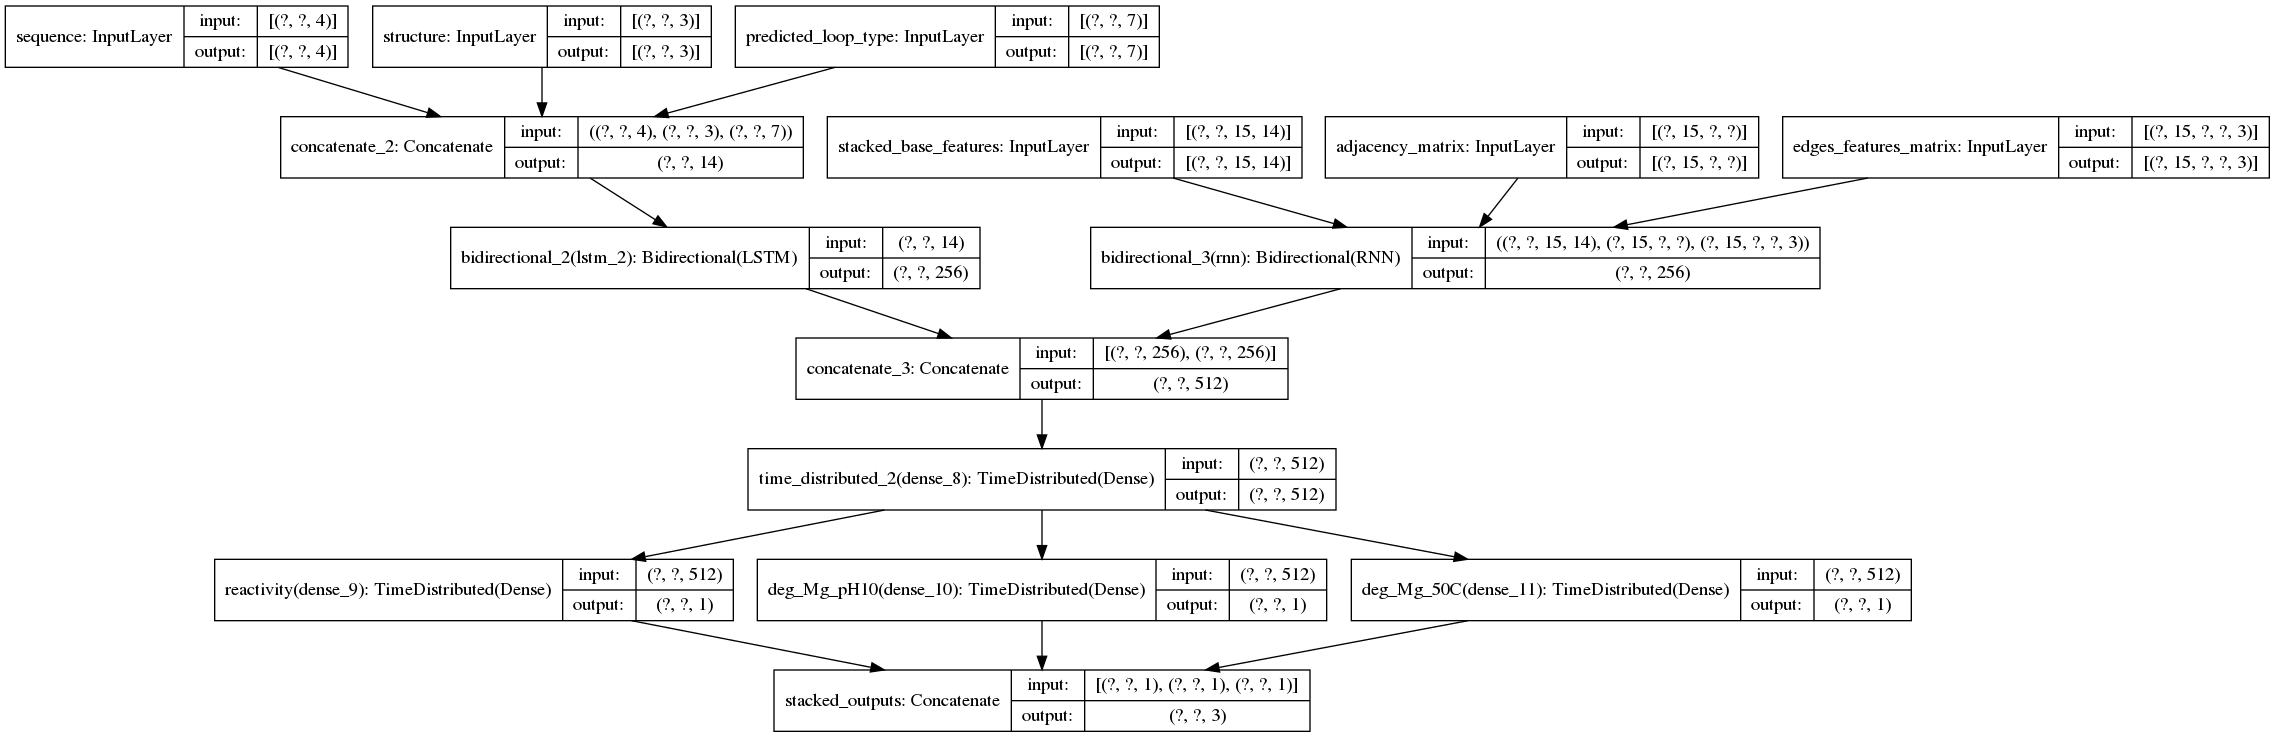

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [14]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
structure (InputLayer)          [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
predicted_loop_type (InputLayer [(None, None, 7)]    0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, None, 14)     0           sequence[0][0]                   
                                                                 structure[0][0]       

model.evaluate(subgraphed_valid_ds.batch(64))# Additional dataset preparations

In [15]:
subgraphed_train_ds, subgraphed_valid_ds = split_into_train_and_valid(subgraphed_train_valid_ds, split_factor=0.3)

### Baseline training and testing models evaluation

In [16]:
model.evaluate(subgraphed_valid_ds.batch(64))

/home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['seq_scored'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


12/12 [==============================] - 2s 184ms/step - loss: 0.6887


0.6887204647064209

# Model training

In [17]:
%tensorboard --logdir $log_dir

Reusing TensorBoard on port 6006 (pid 315), started 0:44:32 ago. (Use '!kill 315' to kill it.)

In [18]:
history = model.fit(subgraphed_train_ds.batch(32),
                    validation_data=subgraphed_valid_ds.batch(4096),
                    epochs=100,
                    initial_epoch=0,
                    verbose=1,
                    shuffle=True,
                    callbacks=[tensorboard_callback, model_checkpoint_callback])

Epoch 1/100
 1/53 [..............................] - ETA: 0s - loss: 0.7536WARNING:tensorflow:From /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
26/53 [=============>................] - ETA: 30s - loss: 0.5490

KeyboardInterrupt: 

# Create submission

In [48]:
%time submission = create_submission(model, [subgraphed_public_test_ds, subgraphed_private_test_ds], [raw_public_test_ds, raw_private_test_ds])
submission

CPU times: user 39 s, sys: 7.13 s, total: 46.1 s
Wall time: 34.9 s


,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.741164,0.907594,0.0,0.649330,0.0
1,id_00073f8be_1,1.932714,2.850757,0.0,2.705823,0.0
2,id_00073f8be_2,1.477123,1.080878,0.0,1.317502,0.0
3,id_00073f8be_3,1.196339,0.866009,0.0,1.126716,0.0
4,id_00073f8be_4,0.920026,0.752350,0.0,0.946930,0.0
...,...,...,...,...,...,...
316222,id_ffda94f24_86,0.245026,0.542082,0.0,0.425844,0.0
316223,id_ffda94f24_87,0.575511,1.262956,0.0,1.035617,0.0
316224,id_ffda94f24_88,0.997710,1.428020,0.0,1.264681,0.0
316225,id_ffda94f24_89,0.722098,1.182843,0.0,0.941708,0.0


In [49]:
submission_name = 'submission.csv'
submissions_dir = os.path.join(os.getcwd(), 'submissions')
submission_path = os.path.join(submissions_dir, submission_name)
submission.to_csv(submission_path, header=True, index=False)

# Model saving and loading

In [53]:
loaded_model = tf.keras.models.load_model(model_path, custom_objects={'mcrmse': mcrmse, 'GraphLSTMCell': GraphLSTMCell})

In [54]:
# loaded_model.evaluate(subgraphed_valid_ds.batch(4096))

/home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['seq_scored'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


1/1 [==============================] - 0s 1ms/step - loss: 0.4208


0.4208168387413025

In [22]:
# model = loaded_model

In [52]:
model.save(model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /home/jan/kaggle_competitions/covid/models/model/assets


TODO:
* cross-validation - more data to train
* signal_to_noise parameter - maybe it can be used in some way
* unsupervised pretraining